#### Query Construction

In [1]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain.prompts import ChatPromptTemplate

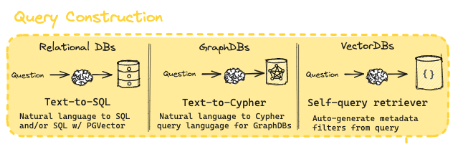

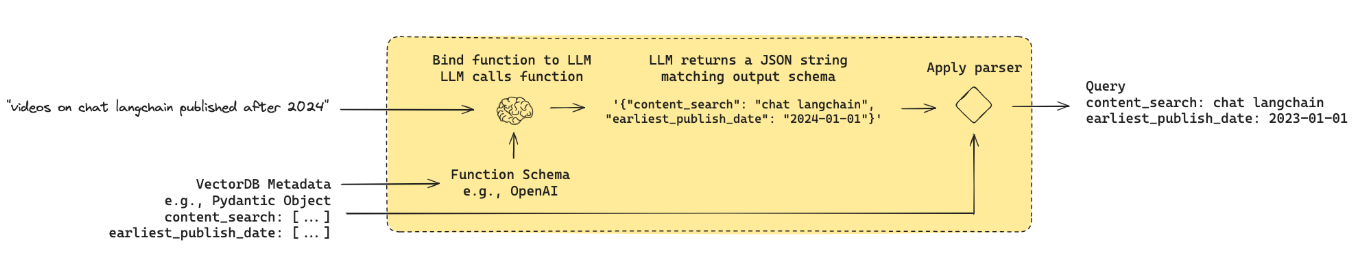

In [2]:
# Many vectorstores contain metadata fields.
# This makes it possible to filter for specific chunks based on metadata.
# We can use the query construction to convert it like we wanted with the help of pydantic BaseModel

In [15]:
import yt_dlp

def get_video_info(url):
    ydl_opts = {}
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(url, download=False)
        print(f"Title: {info.get('title')}")
        print(f"Uploader: {info.get('uploader')}")
        print(f"Upload Date: {info.get('upload_date')}")
        print(f"Views: {info.get('view_count')}")
        print(f"Duration: {info.get('duration')} seconds")
        print(f"Description: {info.get('description')[:200]}...")

get_video_info("https://youtu.be/lOdXUVYT69I?si=OlaJFDgATKZE8VhN")


[youtube] Extracting URL: https://youtu.be/lOdXUVYT69I?si=OlaJFDgATKZE8VhN
[youtube] lOdXUVYT69I: Downloading webpage
[youtube] lOdXUVYT69I: Downloading ios player API JSON
[youtube] lOdXUVYT69I: Downloading mweb player API JSON
[youtube] lOdXUVYT69I: Downloading player 3ede36f2
[youtube] lOdXUVYT69I: Downloading m3u8 information


Title: GraphRAG - The Most Advanced Futuristic RAG | Introduction, Setup, Working, Testing
Uploader: Neural Hacks with Vasanth
Upload Date: 20240703
Views: 4533
Duration: 902 seconds
Description: 🎥 Welcome to our channel! Today, we dive into the revolutionary Graph RAG from Microsoft, an advanced retrieval-augmented generation system that enhances AI responses by providing relevant context.

G...


In [16]:
import datetime
from typing import Optional
from langchain_core.pydantic_v1 import BaseModel, Field

class TutorialSearch(BaseModel):
    """Search over a database of tutorial videos about a software library."""

    content_search: str = Field(
        ...,
        description="Similarity search query applied to video transcripts.",
    )
    title_search: str = Field(
        ...,
        description=(
            "Alternate version of the content search query to apply to video titles. "
            "Should be succinct and only include key words that could be in a video "
            "title."
        ),
    )
    min_view_count: Optional[int] = Field(
        None,
        description="Minimum view count filter, inclusive. Only use if explicitly specified.",
    )
    max_view_count: Optional[int] = Field(
        None,
        description="Maximum view count filter, exclusive. Only use if explicitly specified.",
    )
    earliest_publish_date: Optional[datetime.date] = Field(
        None,
        description="Earliest publish date filter, inclusive. Only use if explicitly specified.",
    )
    latest_publish_date: Optional[datetime.date] = Field(
        None,
        description="Latest publish date filter, exclusive. Only use if explicitly specified.",
    )
    min_length_sec: Optional[int] = Field(
        None,
        description="Minimum video length in seconds, inclusive. Only use if explicitly specified.",
    )
    max_length_sec: Optional[int] = Field(
        None,
        description="Maximum video length in seconds, exclusive. Only use if explicitly specified.",
    )

    def pretty_print(self) -> None:
        for field in self.__fields__:
            if getattr(self, field) is not None and getattr(self, field) != getattr(
                self.__fields__[field], "default", None
            ):
                print(f"{field}: {getattr(self, field)}")

c:\Users\admin\anaconda3\envs\env_langchain_tutorial\lib\site-packages\IPython\core\interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [22]:
from langchain_core.prompts import ChatPromptTemplate

system = """You are an expert at converting user questions into database queries. \
You have access to a database of tutorial videos about a software library for building LLM-powered applications. \
Given a question, return a database query optimized to retrieve the most relevant results.

If there are acronyms or words you are not familiar with, do not try to rephrase them."""
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)
llm = ChatGroq(model="llama-3.3-70b-versatile",temperature=0.5,max_retries=2)
structured_llm = llm.with_structured_output(TutorialSearch)
query_analyzer = prompt | structured_llm

In [23]:
query_analyzer.invoke({"question":"rag from scratch"}).pretty_print()

content_search: building from scratch
title_search: RAG tutorial


In [24]:
query_analyzer.invoke({"question":"Provide me the blogs on rag published in 2024"}).pretty_print()

content_search: rag
title_search: rag
earliest_publish_date: 2024-01-01
latest_publish_date: 2024-12-31


In [25]:
query_analyzer.invoke(
    {
        "question": "how to use multi-modal models in an agent, only videos under 5 minutes"
    }
).pretty_print()

content_search: multi-modal models in an agent
title_search: multi-modal agent
max_length_sec: 300
